<a href="https://colab.research.google.com/github/kalebmes/ML-and-DL-projects/blob/main/Chest%20X_ray%20classification/Efficientnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!mkdir ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download paultimothymooney/chest-xray-pneumonia --unzip --force

100% 2.29G/2.29G [00:20<00:00, 205MB/s]
100% 2.29G/2.29G [00:20<00:00, 122MB/s]


In [5]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os
import torchvision.datasets as dset
import torchvision.transforms as T

In [6]:
data_path = os.path.join('/content', 'chest_xray', 'chest_xray')
train_path = os.path.join(data_path, 'train')
validation_path = os.path.join(data_path, 'val')
test_path = os.path.join(data_path, 'test')

In [7]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
train_augs = T.Compose([T.RandomHorizontalFlip(p=0.5), 
                        T.RandomRotation(degrees=(-20, +20)), 
                        T.Resize((224, 224)),
                        T.ToTensor()])

valid_augs = T.Compose([T.Resize((224, 224)), T.ToTensor()])

In [8]:
trainset = ImageFolder(train_path, transform=train_augs)
validset = ImageFolder(validation_path, transform=valid_augs)
print(f"Total no. of examples in trainset : {len(trainset)}")
print(f"Total no. of examples in validset : {len(validset)}")

Total no. of examples in trainset : 5216
Total no. of examples in validset : 16


In [9]:
print(trainset.class_to_idx)

{'NORMAL': 0, 'PNEUMONIA': 1}


chosen index:  159


Text(0.5, 1.0, '0')

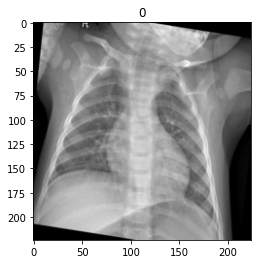

In [10]:
#we can view some images and their labels
import matplotlib.pyplot as plt
idx = np.random.randint(low=0, high=len(trainset)-1)
print('chosen index: ', idx)
image, label = trainset[idx] # the image has format of h, w, c -> so it have to be reshaped
plt.imshow(image.permute(1, 2, 0))
plt.title(label)

In [11]:
lr = 1e-3
batch_size = 8
epochs = 30

#device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'using {device} device')

using cuda device


In [12]:
#now let's read the dataset using pytorch's dataloader
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, )
validloader = DataLoader(validset, batch_size=batch_size)
print('total batches in trainloader: ', len(trainloader), 'and validloader: ', len(validloader))

total batches in trainloader:  652 and validloader:  2


In [14]:
from torchvision import models
model = models.efficientnet_b7(pretrained=True)
model.classifier[1] = nn.Sequential(
    nn.Linear(model.classifier[1].in_features, 500),
    nn.ReLU(inplace=True),
    nn.Linear(500,1),
    nn.Sigmoid()
)
model.to(device)

EfficientNet(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
            (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): ConvNormActivatio

In [15]:
def binary_accuracy(y_pred, y_true):
  y_pred[y_pred >= 0.5] = 1
  y_pred[y_pred < 0.5] = 0
  return torch.mean((y_pred == y_true).type(torch.FloatTensor))

In [16]:
from tqdm import tqdm

def train_model(model, dataloader, optimizer, current_epoch):

  model.train()
  total_loss = 0.0
  total_acc = 0.0
  tk = tqdm(dataloader, desc='EPOCH' + '[TRAIN]' + str(current_epoch + 1) + "/" + str(epochs))

  for t, data in enumerate(tk):
    images, labels = data
    labels = labels.reshape(-1, 1).float()
    images, labels = images.to(device), labels.to(device)

    # logits, loss = model(images, labels)
    logits = model(images)
    loss = nn.BCELoss()(logits, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
    total_acc += binary_accuracy(logits, labels)
    tk.set_postfix({'loss': float(total_loss/(t+1)),'acc': float(total_acc/(t+1))})
  return total_loss/len(dataloader), total_acc / len(dataloader)

def eval_model(model, dataloader, current_epoch):

  model.eval()
  total_loss = 0.0
  total_acc = 0.0
  tk = tqdm(dataloader, desc='EPOCH' + '[VALID]' + str(current_epoch + 1) + "/" + str(epochs))

  for t, data in enumerate(tk):
    images, labels = data
    labels = labels.reshape(-1, 1).float()
    images, labels = images.to(device), labels.to(device)

    # logits, loss = model(images, labels)
    logits = model(images)
    loss = nn.BCELoss()(logits, labels)

    total_loss += loss.item()
    total_acc += binary_accuracy(logits, labels)
    tk.set_postfix({'loss': float(total_loss/(t+1)),'acc': float(total_acc/(t+1))})
  return total_loss/len(dataloader), total_acc / len(dataloader)

In [17]:
#now let's train the model
from torch import optim
optimizer = optim.Adam(model.parameters(), lr=lr)
# optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.5, weight_decay=1e-2, nesterov=True)

In [18]:
for images, labels in trainset:
  break
print('images batch shape: ', images.shape)
print('labels batch shape', labels)

images batch shape:  torch.Size([3, 224, 224])
labels batch shape 0


In [19]:
best_valid_loss = np.Inf
train_losses, valid_losses = [], []
train_accuracies, valid_accuracies = [], []
for i in range(epochs):
  train_loss, train_acc = train_model(model, trainloader, optimizer, i)
  valid_loss, valid_acc = eval_model(model, validloader, i)
  train_losses.append(train_loss)
  valid_losses.append(valid_loss)
  train_accuracies.append(train_acc)
  valid_accuracies.append(valid_acc)
  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best-weights.pt')
    print('SAVED BEST WEIGHTS')
    best_valid_loss = valid_loss
print()
print()
print('accuracy on the training set: ', float(train_acc))
print('accuracy on the validation set: ', float(valid_acc))

EPOCH[VALID]1/30: 100%|██████████| 2/2 [00:00<00:00,  3.94it/s, loss=19, acc=0.688]


SAVED BEST WEIGHTS


EPOCH[VALID]2/30: 100%|██████████| 2/2 [00:00<00:00,  4.53it/s, loss=0.587, acc=0.688]


SAVED BEST WEIGHTS


EPOCH[VALID]4/30: 100%|██████████| 2/2 [00:00<00:00,  4.54it/s, loss=0.515, acc=0.688]


SAVED BEST WEIGHTS


EPOCH[VALID]7/30: 100%|██████████| 2/2 [00:00<00:00,  3.72it/s, loss=0.415, acc=0.812]


SAVED BEST WEIGHTS


EPOCH[VALID]8/30: 100%|██████████| 2/2 [00:00<00:00,  4.45it/s, loss=0.143, acc=0.938]


SAVED BEST WEIGHTS


EPOCH[VALID]11/30: 100%|██████████| 2/2 [00:00<00:00,  4.77it/s, loss=0.114, acc=0.938]


SAVED BEST WEIGHTS


EPOCH[VALID]13/30: 100%|██████████| 2/2 [00:00<00:00,  4.68it/s, loss=0.0721, acc=1]


SAVED BEST WEIGHTS


EPOCH[VALID]30/30: 100%|██████████| 2/2 [00:00<00:00,  4.61it/s, loss=0.315, acc=0.812]



accuracy on the training set:  0.9875383377075195
accuracy on the validation set:  0.8125


In [20]:
def plot_the_loss_curve(epochs, training_losses, validation_losses):
  """Plot a curve of loss vs. epoch."""
  epochs = list(range(1, epochs + 1))
  plt.figure(figsize=(10, 5))
  plt.xlabel("Epoch")
  plt.ylabel("Cross Entropy losses")

  plt.plot(epochs[1:], training_losses[1:], label="Training Loss")
  plt.plot(epochs[1:], validation_losses[1:], label="Validation Loss")
  plt.legend()
  
  # We're not going to plot the first epoch, since the loss on the first epoch
  # is often substantially greater than the loss for other epochs.
  merged_losses = training_losses[1:] + validation_losses[1:]
  highest_loss = max(merged_losses)
  lowest_loss = min(merged_losses)
  delta = highest_loss - lowest_loss
  print(delta)

  top_of_y_axis = highest_loss + (delta * 0.05)
  bottom_of_y_axis = lowest_loss - (delta * 0.05)
  plt.title('loss curve') 
  plt.ylim([bottom_of_y_axis, top_of_y_axis])
  plt.show()

2.9319236166220453


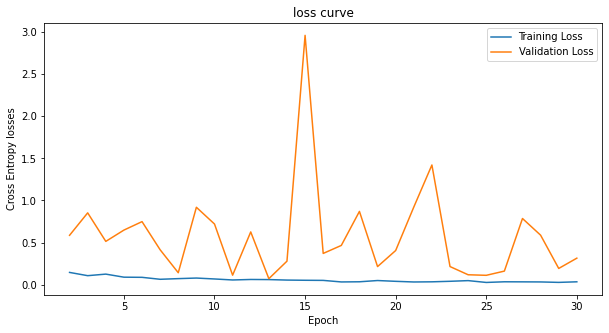

In [21]:
plot_the_loss_curve(epochs, train_losses, valid_losses)